<a href="https://colab.research.google.com/github/gmihaila/machine_learning_things/blob/master/attention_mechanisms/tf2_0_attention_mechanisms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Sun Feb  9 15:24:01 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.48.02    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

### Imports

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
# tf.debugging.set_log_device_placement(True)
import tensorflow_datasets as tfds
import tensorflow_hub as hub
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import time
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

EMBEDDING_SIZE = 100
BUFFER_SIZE = 1000
BATCH = 1000
EPOCHS = 20
MAX_LEN = 500

TensorFlow 2.x selected.
Num GPUs Available:  1


### Functions

In [0]:
def pad_generator(data_generator, max_len=500, valid_split=False, test=0.3):
  data = []
  labels = []
  [(data.append(val), labels.append(label)) for val, label in data_generator]
  if max_len == -1:
    max_len = max([len(instance) for instance in data])
  data = tf.keras.preprocessing.sequence.pad_sequences(sequences=data, 
                                                       maxlen=max_len, 
                                                       dtype='int64', 
                                                       padding='post', 
                                                       truncating='post', 
                                                       value=0)
  labels = np.array(labels, dtype='int64')
  print(data.shape, labels.shape)
  if valid_split:
    X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=test)
    train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    test = tf.data.Dataset.from_tensor_slices((X_test, y_test))
    return train, test
  else:
    dataset = tf.data.Dataset.from_tensor_slices((data, labels))
    return dataset


def plt_history(history_dict, 
                acc_key='accuracy', val_acc_key='val_accuracy', 
                loss_key='loss', val_loss_key='val_loss'):
  acc = history_dict[acc_key]
  val_acc = history_dict[val_acc_key]
  loss = history_dict[loss_key]
  val_loss = history_dict[val_loss_key]
  epochs = range(1, len(acc) + 1)
  plt.subplot(1, 2, 1)
  # "bo" is for "blue dot"
  plt.plot(epochs, loss, 'bo', label='Training loss')
  # b is for "solid blue line"
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.grid()
  plt.tight_layout()
  plt.xticks(epochs)


  plt.subplot(1, 2, 2)
  plt.plot(epochs, acc, 'bo', label='Training acc')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend(loc='lower right')
  plt.grid()
  plt.tight_layout()
  plt.xticks(epochs)
  fig = plt.gcf()
  fig.set_size_inches(15, 5)
  plt.show()
  return

### Dataset

In [4]:
# Use the version pre-encoded with an ~8k vocabulary.
# Return the train/test datasets as a tuple.
# Return (example, label) pairs from the dataset (instead of a dictionary).
# Also return the `info` structure. 

(train_data, test_data), info = tfds.load('imdb_reviews/subwords8k', 
                                          split = (tfds.Split.TRAIN, tfds.Split.TEST),
                                          as_supervised=True,
                                          with_info=True)

text_encoder = info.features['text'].encoder
print ('Vocabulary size: {}'.format(text_encoder.vocab_size))

train_data, valid_data = pad_generator(data_generator=train_data, 
                                       max_len=MAX_LEN, 
                                       valid_split=True, 
                                       test=0.3)

test_data = pad_generator(data_generator=test_data, 
                                       max_len=MAX_LEN)

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteC05WFF/imdb_reviews-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteC05WFF/imdb_reviews-test.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteC05WFF/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0. Subsequent calls will reuse this data.
Vocabulary size: 8185
(25000, 500) (25000,)
(25000, 500) (25000,)


### Prepare the data for training

In [5]:
# batch padding
train_batches = (train_data.shuffle(BUFFER_SIZE).batch(BATCH))
valid_batches = (valid_data.shuffle(BUFFER_SIZE).batch(BATCH))
test_batches = (test_data.shuffle(BUFFER_SIZE).batch(BATCH))

# sample
encodings, labels = next(iter(train_batches))

print("Text:                  {}".format(text_encoder.decode(encodings[0])))
print("Encoding sample:       {}".format(encodings[0][:10]))
print("Label:                 {}".format(labels[0]))
print("Encoding batch shape:  {}".format(encodings.shape))
print("Labels batch shape:    {}".format(labels.shape))

Text:                  Picture the fugly annoying goth kids from college in a scat film, throw in a pinch of story and a whole lot of awful acting, and you are still not even close to how bad this movie is.<br /><br />Shot badly, bad effects, worse acting. Contrived attempt at shocking horror. Everyone I've showed this to gets kinda depressed watching it. The sex scenes are disturbing, not necessarily for their content, but more because they're just something you want to end as soon as possible. The last sex scene is just foul, even before she gets to the guy.<br /><br />I'm one of those people that loves to watch movies that people hate, which is why I picked this one up. But for your own sake, save yourself the time and avoid this abhorrence. It's that bad. I literally threw it in the garbage.
Encoding sample:       [7369 7961    1 1587 3908   47 1517 4357  282  671]
Label:                 0
Encoding batch shape:  (1000, 500)
Labels batch shape:    (1000,)


### Encoder

The input is put through an encoder model which gives us the encoder output of shape (batch_size, max_length, hidden_size) and the encoder hidden state of shape (batch_size, hidden_size).

In [6]:
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
  def call(self, x, hidden):
    x = self.embedding(x)
    output, state = self.gru(x, initial_state = hidden)
    return output, state

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))

encoder = Encoder(vocab_size=text_encoder.vocab_size, embedding_dim=100, enc_units=102, batch_sz=BATCH)

initial_state = encoder.initialize_hidden_state()

encoder_outputs, last_output = encoder(encodings, initial_state)

print("encodings                {}".format(encodings.shape))
print("encoder_output           {}".format(encoder_outputs.shape))
print("last_state               {}".format(last_output.shape))
print("initialize_hidden_state  {}".format(initial_state.shape))

encodings                (1000, 500)
encoder_output           (1000, 500, 102)
last_state               (1000, 102)
initialize_hidden_state  (1000, 102)


### CustomAttention - Fixed Padding

In [7]:
class CustomAttention(tf.keras.layers.Layer):
  """Implements CustomAttention attention scoring using small neural networks.
  Works great for single classificaiton prediciton.
  Add multiple dense layer to increase attention neural netowrk (a1, a2, etc.).

  Temrinology:
    'max_len' refers to sequence maximum length
    'hidden_size' / 'query_depth' / 'alignments_size' refers to rnn_size.
    'key' / 'keys' are 'encoder outputs' related values with 
      shape `[batch_size x max_len x hidden size]`
    'query' / 'value'(s) refers to decoder values with 
      shape `[batch_size x hidden size]`

  Source:
  https://github.com/conversationai/conversationai-models/blob/master/attention-tutorial/Attention_Model_Tutorial.ipynb
  """
  def __init__(self, max_len, rnn_size, attention_size):
    """Construct the AttentionMechanism.

    Args:
      max_len: sequence maximum length.
      rnn_size: number of hidden units in rnn cell.
      attention_size: The size of layer for neural network scoring prediciton.
    """

    super(CustomAttention, self).__init__()
    self.max_len = max_len
    self.rnn_size = rnn_size
    # attention layer
    self.a1 = tf.keras.layers.Dense(units=attention_size, activation=tf.nn.relu)
    # last layer that outputs scoring value
    self.V = tf.keras.layers.Dense(1, activation=None)

  def call(self, encoder_output):
    """Score based on the decoder and encoder outputs.

    Args:
      encoder_output: Tensor with shape `[batch_size, rnn_size]`
    Returns:
      context: The weighted average sum of encoder output with 
        shape `[batch_size, rnn_size]`
      attention_weights: The attention with shape `[batch_size, max_len]`
    """
    # concatenate sequences vertically
    encoder_output = tf.concat(encoder_output, axis = 2)
    # reshape to [batch_size*max_len, rnn_size]
    intermediate_values = tf.reshape(encoder_output, [-1, self.rnn_size])
    # feed to each layer
    intermediate_values = self.a1(intermediate_values)
    intermediate_values = self.V(intermediate_values)
    # reshape to [batch_size, max_len, 1]
    scores = tf.reshape(intermediate_values, [-1, self.max_len, 1])
    attention_weights = tf.nn.softmax(logits=scores, axis=1)
    context_vector = tf.reduce_sum(encoder_output * attention_weights, 1)
    # match shape [batch_size, max_len]
    attention_weights = tf.squeeze(attention_weights)
    return context_vector, attention_weights


custom_attn = CustomAttention(max_len=MAX_LEN, rnn_size=102, attention_size=10)

context_vector, attention_weights = custom_attn(encoder_outputs)

print("Attention result shape [context_vector]: (batch size, units) {}".format(context_vector.shape))
print("Attention weights shape: (batch_size, sequence_length, 1)    {}".format(attention_weights.shape))

Attention result shape [context_vector]: (batch size, units) (1000, 102)
Attention weights shape: (batch_size, sequence_length, 1)    (1000, 500)


### CustomAttention - Batch Padding

In [8]:
class CustomAttention(tf.keras.layers.Layer):
  """Implements CustomAttention attention scoring using small neural networks.
  Works great for single classificaiton prediciton.

  Temrinology:
    'max_len' refers to sequence maximum length
    'hidden_size' / 'query_depth' refers to RNN size.
    'key' / 'keys' are 'encoder outputs' related values with 
      shape `[batch_size x max_len x hidden size]`
    'query' / 'value'(s) refers to decoder values with 
      shape `[batch_size x hidden size]`

  Source:
  https://github.com/conversationai/conversationai-models/blob/master/attention-tutorial/Attention_Model_Tutorial.ipynb
  """
  def __init__(self, attention_size, attention_depth):
    """Construct the AttentionMechanism.

    Args:
      attention_size: The size of layer for neural network scoring prediciton.
      attention_depth: The number of layer for neural network scoring prediciton.
    """

    super(CustomAttention, self).__init__()
    self.attention_depth = attention_depth
    self.attention_size = attention_size
    # last layer that outputs scoring value
    self.V = tf.keras.layers.Dense(1, activation=None)

  def call(self, encoder_output):
    """Score based on the decoder and encoder outputs.

    Args:
      encoder_output: Tensor with shape `[batch_size, rnn_size]`
    Returns:
      context: The weighted average sum of encoder output with 
        shape `[batch_size, rnn_size]`
      attention_weights: The attention with shape `[batch_size, max_len]`
    """

    # concatenate sequences vertically
    encoder_output = tf.concat(encoder_output, axis = 2)
    encoder_shape = encoder_output.shape
    sequence_length = encoder_shape[1]
    final_layer_size = encoder_shape[2]
    # reshape to [batch_size*max_len, rnn_size]
    x = tf.reshape(encoder_output, [-1, final_layer_size])
    # feed to each layer
    for _ in range(self.attention_depth-1):
      x = tf.keras.layers.Dense(units=self.attention_size, activation=tf.nn.relu)(x)
    x = self.V(x)
    # reshape to [batch_size, max_len, 1]
    scores = tf.reshape(x, [-1, sequence_length, 1])
    attention_weights = tf.nn.softmax(logits=scores, axis=1)
    context_vector = tf.reduce_sum(encoder_output * attention_weights, 1)
    # match shape [batch_size, max_len]
    attention_weights = tf.squeeze(attention_weights)
    return context_vector, attention_weights

custom_attn = CustomAttention(attention_size=10, attention_depth=2)

context_vector, attention_weights = custom_attn(encoder_outputs)

print("Attention result shape [context_vector]: (batch size, units) {}".format(context_vector.shape))
print("Attention weights shape: (batch_size, sequence_length, 1)    {}".format(attention_weights.shape))

Attention result shape [context_vector]: (batch size, units) (1000, 102)
Attention weights shape: (batch_size, sequence_length, 1)    (1000, 500)


### BahdanauAttention

* FC = Fully connected (dense) layer
* EO = Encoder output
* H = hidden state
* X = input to the decoder

And the pseudo-code:

* `score = FC(tanh(FC(EO) + FC(H)))`
* `attention weights = softmax(score, axis = 1)`. Softmax by default is applied on the last axis but here we want to apply it on the *1st axis*, since the shape of score is *(batch_size, max_length, hidden_size)*. `Max_length` is the length of our input. Since we are trying to assign a weight to each input, softmax should be applied on that axis.
* `context vector = sum(attention weights * EO, axis = 1)`. Same reason as above for choosing axis as 1.
* `embedding output` = The input to the decoder X is passed through an embedding layer.
* `merged vector = concat(embedding output, context vector)`
* This merged vector is then given to the GRU

In [9]:
class BahdanauAttention(tf.keras.layers.Layer):
  """Implements BahdanauAttention attention scoring.

  Temrinology:
    'max_len' refers to sequence maximum length
    'rnn_size' / 'hidden_size' / 'query_depth' / 'alignments_size' refers 
      to RNN size.
    'key' / 'keys' are 'encoder outputs' related values with 
      shape `[batch_size x max_len x hidden size]`
    'query' / 'value'(s) refers to decoder values with 
      shape `[batch_size x hidden size]`

  Source:
  https://github.com/tensorflow/docs/blob/master/site/en/tutorials/text/nmt_with_attention.ipynb
  """
  def __init__(self, units):
    """Construct the AttentionMechanism.

    Args:
      units: number of neurons in layer of neural network scoring aproximation.
    """
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, decoder_input, encoder_output):
    """Score the query based on the decoder and encoder outputs.

    Args:
      decoder_input: Tensor with shape `[batch_size, rnn_size]`.
      encoder_output: Tensor with shape `[batch_size, max_len, rnn_size]`
    Returns:
      context: The weighted average sum of encoder output with 
        shape `[batch_size, rnn_size]`
      attention_weights: The attention with shape `[batch_size, max_len]`
    """
    # decoder_input == (batch_size, hidden size)
    # decoder_input to shape == (batch_size, 1, hidden size)
    # we are doing this to perform addition to calculate the score
    decoder_input = tf.expand_dims(decoder_input, 1)
    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(self.W1(encoder_output) + self.W2(decoder_input)))
    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)
    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * encoder_output
    context_vector = tf.reduce_sum(context_vector, axis=1)
    # match shape [batch_size, max_len]
    attention_weights = tf.squeeze(attention_weights)
    return context_vector, attention_weights


## initial_state - might always be 0 because we use only deocder
attention_layer = BahdanauAttention(10)
context_vector, attention_weights = attention_layer(initial_state, encoder_outputs)

print("Attention result shape [context_vector]: (batch size, units) {}".format(context_vector.shape))
print("Attention weights shape: (batch_size, sequence_length, 1)    {}".format(attention_weights.shape))

Attention result shape [context_vector]: (batch size, units) (1000, 102)
Attention weights shape: (batch_size, sequence_length, 1)    (1000, 500)


### LuongAttention

In [10]:
class LuongAttention(tf.keras.Model):
  """Implements Luong-style attention scoring.

  Temrinology:
    'max_len' refers to sequence maximum length
    'hidden_size' / 'query_depth' / 'allignment_size' refers to RNN size.
    'key' / 'keys' are 'encoder outputs' related values with 
      shape `[batch_size x max_len x hidden size]`
    'query' / 'value'(s) refers to decoder values with 
      shape `[batch_size x hidden size]`

  Implementation of all 3 variants: dot, general, concat.
  Source:
  https://github.com/ChunML/NLP/blob/master/machine_translation/train_luong_tf2.py
  """

  def __init__(self, rnn_size, attention_func):
    """Construct the AttentionMechanism.

    Args:
      rnn_size: The hidden state size of RNN cell.
      attention_func: The attention score function. Can be one of the following:
        'dot' 
        'general'
        'concat'
    """
    super(LuongAttention, self).__init__()
    self.attention_func = attention_func

    if attention_func not in ['dot', 'general', 'concat']:
      raise ValueError(
      'Unknown attention score function! Must be either dot, general or concat.')
    if attention_func == 'general':
      # General score function
      self.wa = tf.keras.layers.Dense(rnn_size)
    elif attention_func == 'concat':
      # Concat score function
      self.wa = tf.keras.layers.Dense(rnn_size, activation='tanh')
      self.va = tf.keras.layers.Dense(1)

  def call(self, decoder_output, encoder_output):
    """Score the query based on the decoder and encoder outputs.

    Args:
      decoder_output: Tensor with shape `[batch_size, rnn_size]`.
      encoder_output: Tensor with shape `[batch_size, max_len, rnn_size]`
    Returns:
      context: The weighted average sum of encoder output with 
        shape `[batch_size, rnn_size]`
      alignment: The attention with shape `[batch_size, max_len]`
    """
    
    # match shape [batch_size, 1, rnn_size]
    decoder_output = tf.expand_dims(decoder_output, 1)

    if self.attention_func == 'dot':
      # Dot score function: decoder_output (dot) encoder_output
      # decoder_output has shape: (batch_size, 1, rnn_size)
      # encoder_output has shape: (batch_size, max_len, rnn_size)
      # => score has shape: (batch_size, 1, max_len)
      score = tf.matmul(decoder_output, encoder_output, transpose_b=True)
    elif self.attention_func == 'general':
      # General score function: decoder_output (dot) (Wa (dot) encoder_output)
      # decoder_output has shape: (batch_size, 1, rnn_size)
      # encoder_output has shape: (batch_size, max_len, rnn_size)
      # => score has shape: (batch_size, 1, max_len)
      score = tf.matmul(decoder_output, self.wa(encoder_output), transpose_b=True)
    elif self.attention_func == 'concat':
      # Concat score function: va (dot) tanh(Wa (dot) concat(decoder_output + encoder_output))
      # Decoder output must be broadcasted to encoder output's shape first
      decoder_output = tf.tile(decoder_output, [1, encoder_output.shape[1], 1])
      # Concat => Wa => va
      # (batch_size, max_len, 2 * rnn_size) => (batch_size, max_len, rnn_size) => (batch_size, max_len, 1)
      score = self.va(self.wa(tf.concat((decoder_output, encoder_output), axis=-1)))
      # Transpose score vector to have the same shape as other two above
      # (batch_size, max_len, 1) => (batch_size, 1, max_len)
      score = tf.transpose(score, [0, 2, 1])
    # attention_weights a_t = softmax(score)
    attention_weights = tf.nn.softmax(score, axis=2)
    # context vector c_t is the weighted average sum of encoder output
    context = tf.matmul(attention_weights, encoder_output)
    # match size [batch_size, max_len]
    attention_weights = tf.squeeze(attention_weights)
    # match size [batch_size, rnn_size]
    context = tf.squeeze(context, 1)
    return context, attention_weights


## initial_state - might always be 0 because we use only deocder
attention_layer = LuongAttention(rnn_size=102, attention_func='dot')
context_vector, attention_weights = attention_layer(initial_state, encoder_outputs)

print("Attention result shape [context_vector]: (batch size, units) {}".format(context_vector.shape))
print("Attention weights shape: (batch_size, sequence_length, 1)    {}".format(attention_weights.shape))

Attention result shape [context_vector]: (batch size, units) (1000, 102)
Attention weights shape: (batch_size, sequence_length, 1)    (1000, 500)


### Decoder

In [0]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)

    # used for attention
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden, enc_output):
    # enc_output shape == (batch_size, max_length, hidden_size)
    context_vector, attention_weights = self.attention(hidden, enc_output)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
    x = self.fc(output)

    return x, state, attention_weights

### Regular Classification [word embeedings]

#### Sequential Model + regular train

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 100)         818500    
_________________________________________________________________
global_average_pooling1d (Gl (None, 100)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 16)                1616      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 17        
Total params: 820,133
Trainable params: 820,133
Non-trainable params: 0
_________________________________________________________________
Train for 18 steps, validate for 8 steps
Epoch 1/20
18/18 [==============================] - 3s 175ms/step - loss: 0.6924 - accuracy: 0.5628 - val_loss: 0.6912 - val_accuracy: 0.6744
Epoch 2/20
18/18 [==============================] - 2s 130ms/step

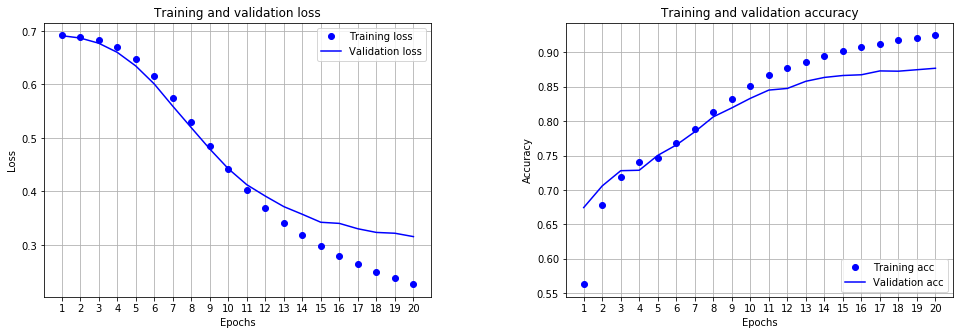

              precision    recall  f1-score   support

           0       0.86      0.85      0.86     12500
           1       0.86      0.86      0.86     12500

    accuracy                           0.86     25000
   macro avg       0.86      0.86      0.86     25000
weighted avg       0.86      0.86      0.86     25000



In [12]:
def model_predicitons(data_generator):
  """Predict on test data.
  Make sure train_generator is already batched formatted.
  """
  # models used
  global model
  y_pred = []
  y_true = []
  # make predicitons
  for batch, (inputs_batch, labels_batch) in enumerate(data_generator):
    preds_batch = model(inputs_batch)
    preds_batch = tf.keras.backend.round(preds_batch)
    [y_pred.append(val[0]) for val in preds_batch]
    [y_true.append(val) for val in labels_batch]
  return np.array(y_true), np.array(y_pred)

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(text_encoder.vocab_size, EMBEDDING_SIZE))
model.add(tf.keras.layers.GlobalAveragePooling1D())
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.summary()

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
# use test as valid 
history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=valid_batches,
                    verbose=1)

results = model.evaluate(test_batches, verbose=2)

plt_history(history_dict=history.history)

# evaluate
y_true, y_pred = model_predicitons(test_data.batch(15000))
print(classification_report(y_true, y_pred))

#### Sequential Model + gradient tape


Need signature if each batch different shape:
```python
@tf.function(input_signature=[
     tf.TensorSpec(shape=[None, None], dtype=tf.int64),
     tf.TensorSpec(shape=[None,], dtype=tf.int64)])
```



**Notes:**

* Apply with logits if we apply optimizer to values coming form softmax
* if sequence varies, use funcion signature and specify exact tensor shape and dtype
* Specify Global Scope variables that will be used in functions

Epoch: 1/20 loss: 0.6921 acc: 0.5129 val_loss: 0.6903 val_acc: 0.5243	Time epoch: 2.89 batch: 0.16
Epoch: 2/20 loss: 0.6872 acc: 0.5221 val_loss: 0.6829 val_acc: 0.5345	Time epoch: 2.13 batch: 0.12
Epoch: 3/20 loss: 0.6758 acc: 0.5392 val_loss: 0.6675 val_acc: 0.5466	Time epoch: 2.13 batch: 0.12
Epoch: 4/20 loss: 0.6550 acc: 0.5488 val_loss: 0.6426 val_acc: 0.5535	Time epoch: 2.21 batch: 0.12
Epoch: 5/20 loss: 0.6230 acc: 0.5555 val_loss: 0.6076 val_acc: 0.5597	Time epoch: 2.20 batch: 0.12
Epoch: 6/20 loss: 0.5822 acc: 0.5609 val_loss: 0.5673 val_acc: 0.5643	Time epoch: 2.22 batch: 0.12
Epoch: 7/20 loss: 0.5360 acc: 0.5646 val_loss: 0.5244 val_acc: 0.5676	Time epoch: 2.19 batch: 0.12
Epoch: 8/20 loss: 0.4886 acc: 0.5680 val_loss: 0.4834 val_acc: 0.5710	Time epoch: 2.16 batch: 0.12
Epoch: 9/20 loss: 0.4444 acc: 0.5715 val_loss: 0.4481 val_acc: 0.5742	Time epoch: 2.14 batch: 0.12
Epoch: 10/20 loss: 0.4048 acc: 0.5747 val_loss: 0.4172 val_acc: 0.5773	Time epoch: 2.13 batch: 0.12
Epoch: 11

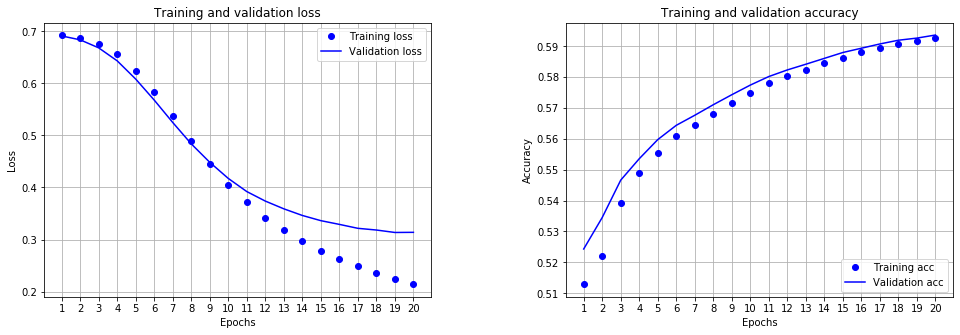

              precision    recall  f1-score   support

           0       0.86      0.85      0.86     12500
           1       0.85      0.87      0.86     12500

    accuracy                           0.86     25000
   macro avg       0.86      0.86      0.86     25000
weighted avg       0.86      0.86      0.86     25000



In [13]:
class Classification(tf.keras.Model):
  def __init__(self, vocab_size, emb_size):
    super(Classification, self).__init__()
    self.emb_layer = tf.keras.layers.Embedding(vocab_size, emb_size)
    self.avg_layer = tf.keras.layers.GlobalAveragePooling1D()
    self.l1 = tf.keras.layers.Dense(units=16, activation=tf.nn.relu)
    self.l2 = tf.keras.layers.Dense(units=1, activation=tf.nn.sigmoid)
    return

  def call(self, input_batch):
    intermediate_value = self.emb_layer(input_batch)
    intermediate_value = self.avg_layer(intermediate_value)
    intermediate_value = self.l1(intermediate_value)
    output_batch = self.l2(intermediate_value)
    return output_batch


def loss_func(target, logits):
  bce = tf.losses.BinaryCrossentropy(from_logits=False)
  return bce(y_true=target, y_pred=logits)

@tf.function
def train_batch(input_batch, label_batch):
  # use global scope variables
  global model, model_optimizer, model_metrics
  loss = 0
  with tf.GradientTape() as tape:
    preds_batch = model(input_batch)
    loss = loss_func(label_batch, preds_batch)
    acc = model_metrics(labels_batch, tf.keras.backend.round(preds_batch))

  variables = model.variables
  gradients = tape.gradient(loss, variables)
  model_optimizer.apply_gradients(zip(gradients, variables))
  return loss, acc

def model_predicitons(data_generator):
  """Predict on test data.
  Make sure train_generator is already batched formatted.
  """
  # models used
  global model
  y_pred = []
  y_true = []
  # make predicitons
  for batch, (inputs_batch, labels_batch) in enumerate(data_generator):
    preds_batch = model(inputs_batch)
    preds_batch = tf.keras.backend.round(preds_batch)
    [y_pred.append(val[0]) for val in preds_batch]
    [y_true.append(val) for val in labels_batch]
  return np.array(y_true), np.array(y_pred)

EPOCHS = 20
history_dict = {'accuracy':[],
                'val_accuracy':[], 
                'loss':[], 
                'val_loss':[]}

with tf.device('/device:GPU:0'):
  
  model = Classification(vocab_size=text_encoder.vocab_size, emb_size=EMBEDDING_SIZE)
  model_optimizer = tf.optimizers.Adam()
  model_metrics = tf.metrics.Accuracy()

  for epoch in range(EPOCHS):
    epoch_time = 0

    # train data
    loss_epoch = 0
    acc_epoch = 0

    for batch, (encodings_batch, labels_batch) in enumerate(train_batches, start=1):
      start_time = time.time()
      # train on batch
      loss_batch, acc_batch = train_batch(encodings_batch, labels_batch)
      # keep track of loss and accuracy
      loss_epoch += loss_batch
      acc_epoch += acc_batch
      end_time = time.time()
      epoch_time += (end_time - start_time)
        
    batch_time = epoch_time / batch
    loss_epoch = tf.get_static_value(loss_epoch) / batch
    history_dict['loss'].append(loss_epoch)
    acc_epoch = tf.get_static_value(acc_epoch) / batch
    history_dict['accuracy'].append(acc_epoch)

    # validation data
    val_acc_epoch = 0
    val_loss_epoch = 0

    for batch, (encodings_bacth, labels_batch) in enumerate(valid_batches, start=1):
      preds_batch = model(encodings_bacth)

      val_loss_epoch += loss_func(labels_batch, preds_batch)
      val_acc_epoch += model_metrics(labels_batch, tf.keras.backend.round(preds_batch))

    val_loss_epoch = tf.get_static_value(val_loss_epoch) / batch
    history_dict['val_loss'].append(val_loss_epoch)

    val_acc_epoch = tf.get_static_value(val_acc_epoch) / batch
    history_dict['val_accuracy'].append(val_acc_epoch)

    print('Epoch: %s/%s loss: %.4f acc: %.4f val_loss: %.4f val_acc: %.4f\tTime epoch: %.2f batch: %.2f'%(epoch+1, 
                                                                                                        EPOCHS, 
                                                                                                        loss_epoch, 
                                                                                                        acc_epoch, 
                                                                                                        val_loss_epoch, 
                                                                                                        val_acc_epoch,
                                                                                                        epoch_time,
                                                                                                        batch_time))    
plt_history(history_dict)

# evaluate
y_true, y_pred = model_predicitons(test_data.batch(15000))
print(classification_report(y_true, y_pred))

#### Separate Models + gradient tape

Need signature if each batch different shape:
```python
@tf.function(input_signature=[
     tf.TensorSpec(shape=[None, None], dtype=tf.int64),
     tf.TensorSpec(shape=[None,], dtype=tf.int64)])
```

Epoch: 1/20 loss: 0.6933 acc: 0.5001 val_loss: 0.6932 val_acc: 0.5003	Time epoch: 2.96 batch: 0.16
Epoch: 2/20 loss: 0.6931 acc: 0.5007 val_loss: 0.6931 val_acc: 0.5003	Time epoch: 2.15 batch: 0.12
Epoch: 3/20 loss: 0.6931 acc: 0.5007 val_loss: 0.6931 val_acc: 0.5069	Time epoch: 2.17 batch: 0.12
Epoch: 4/20 loss: 0.6930 acc: 0.5100 val_loss: 0.6929 val_acc: 0.5090	Time epoch: 2.24 batch: 0.12
Epoch: 5/20 loss: 0.6928 acc: 0.5112 val_loss: 0.6925 val_acc: 0.5142	Time epoch: 2.15 batch: 0.12
Epoch: 6/20 loss: 0.6920 acc: 0.5184 val_loss: 0.6912 val_acc: 0.5231	Time epoch: 2.20 batch: 0.12
Epoch: 7/20 loss: 0.6894 acc: 0.5243 val_loss: 0.6866 val_acc: 0.5284	Time epoch: 2.16 batch: 0.12
Epoch: 8/20 loss: 0.6818 acc: 0.5344 val_loss: 0.6752 val_acc: 0.5417	Time epoch: 2.19 batch: 0.12
Epoch: 9/20 loss: 0.6654 acc: 0.5498 val_loss: 0.6546 val_acc: 0.5586	Time epoch: 2.15 batch: 0.12
Epoch: 10/20 loss: 0.6386 acc: 0.5674 val_loss: 0.6248 val_acc: 0.5762	Time epoch: 2.17 batch: 0.12
Epoch: 11

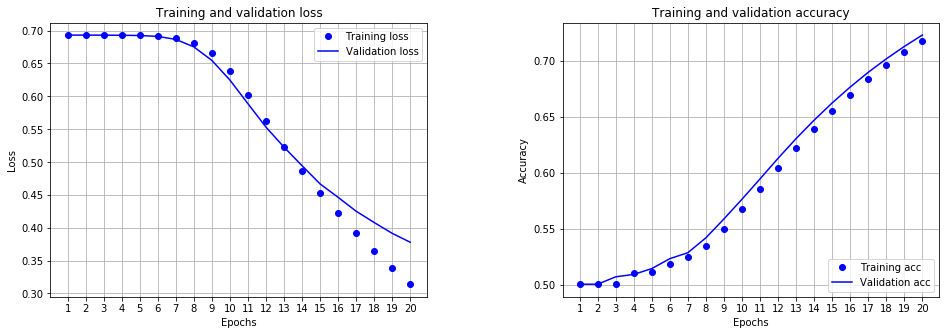

              precision    recall  f1-score   support

           0       0.86      0.86      0.86     12500
           1       0.86      0.86      0.86     12500

    accuracy                           0.86     25000
   macro avg       0.86      0.86      0.86     25000
weighted avg       0.86      0.86      0.86     25000



In [14]:
class Embed(tf.keras.Model):
  def __init__(self, vocab_size, emb_size):
    super(Embed, self).__init__()
    self.emb_layer = tf.keras.layers.Embedding(vocab_size, emb_size)
    self.avg_layer = tf.keras.layers.GlobalAveragePooling1D()
    return

  def call(self, input_batch):
    output_batch = self.emb_layer(input_batch)
    output_batch = self.avg_layer(intermediate_value)
    return output_batch

class Prediction(tf.keras.Model):
  def __init__(self):
    super(Prediction, self).__init__()
    self.l1 = tf.keras.layers.Dense(units=16, activation=tf.nn.relu)
    self.l2 = tf.keras.layers.Dense(units=1, activation=tf.nn.sigmoid)
    return

  def call(self, input_batch):
    intermediate_value = self.l1(input_batch)
    output_batch = self.l2(intermediate_value)
    return output_batch


def loss_func(target, logits):
  bce = tf.losses.BinaryCrossentropy(from_logits=False)
  return bce(y_true=target, y_pred=logits)


@tf.function
def train_batch(input_batch, labels_batch):
  # use global scope variables
  global model_embed, model_dens, model_optimizer
  with tf.GradientTape() as tape:
    preds_batch = model_embed(input_batch)
    preds_batch = model_dens(preds_batch)

    loss = loss_func(labels_batch, preds_batch)
    acc = model_metrics(labels_batch, tf.keras.backend.round(preds_batch))

  variables = model_embed.variables + model_dens.variables
  gradients = tape.gradient(loss, variables)
  model_optimizer.apply_gradients(zip(gradients, variables))
  return loss, acc



def model_predicitons(data_generator):
  """Predict on test data.
  Make sure train_generator is already batched formatted.
  """
  # models used
  global model
  y_pred = []
  y_true = []
  # make predicitons
  for batch, (inputs_batch, labels_batch) in enumerate(data_generator):
    preds_batch = model_embed(inputs_batch)
    preds_batch = model_dens(preds_batch)

    preds_batch = tf.keras.backend.round(preds_batch)
    [y_pred.append(val[0]) for val in preds_batch]
    [y_true.append(val) for val in labels_batch]
  return np.array(y_true), np.array(y_pred)

EPOCHS = 20
history_dict = {'accuracy':[],
                'val_accuracy':[], 
                'loss':[], 
                'val_loss':[]}

with tf.device('/device:GPU:0'):
  
    model_embed = Classification(vocab_size=text_encoder.vocab_size, emb_size=EMBEDDING_SIZE)
    model_dens = Prediction()
    model_optimizer = tf.optimizers.Adam()
    model_metrics = tf.metrics.Accuracy()

    for epoch in range(EPOCHS):
      epoch_time = 0

      # train data
      loss_epoch = 0
      acc_epoch = 0

      for batch, (encodings_batch, labels_batch) in enumerate(train_batches, start=1):
        start_time = time.time()
        # train on batch
        loss_batch, acc_batch = train_batch(encodings_batch, labels_batch)
        # keep track of loss and accuracy
        loss_epoch += loss_batch
        acc_epoch += acc_batch
        end_time = time.time()
        epoch_time += (end_time - start_time)
          
      batch_time = epoch_time / batch
      loss_epoch = tf.get_static_value(loss_epoch) / batch
      history_dict['loss'].append(loss_epoch)
      acc_epoch = tf.get_static_value(acc_epoch) / batch
      history_dict['accuracy'].append(acc_epoch)

      # validation data
      val_acc_epoch = 0
      val_loss_epoch = 0

      for batch, (encodings_bacth, labels_batch) in enumerate(valid_batches, start=1):
        preds_batch = model_embed(encodings_bacth)
        preds_batch = model_dens(preds_batch)

        val_loss_epoch += loss_func(labels_batch, preds_batch)
        val_acc_epoch += model_metrics(labels_batch, tf.keras.backend.round(preds_batch))

      val_loss_epoch = tf.get_static_value(val_loss_epoch) / batch
      history_dict['val_loss'].append(val_loss_epoch)

      val_acc_epoch = tf.get_static_value(val_acc_epoch) / batch
      history_dict['val_accuracy'].append(val_acc_epoch)

      print('Epoch: %s/%s loss: %.4f acc: %.4f val_loss: %.4f val_acc: %.4f\tTime epoch: %.2f batch: %.2f'%(epoch+1, 
                                                                                                          EPOCHS, 
                                                                                                          loss_epoch, 
                                                                                                          acc_epoch, 
                                                                                                          val_loss_epoch, 
                                                                                                          val_acc_epoch,
                                                                                                          epoch_time,
                                                                                                          batch_time))    
plt_history(history_dict)

# evaluate
y_true, y_pred = model_predicitons(test_data.batch(15000))
print(classification_report(y_true, y_pred))

### Attention Classification

In [0]:
rnn_units = 32
attention_dim = 10

#### CustomAttention - Separate Models

Epoch: 1/20 loss: 0.6917 acc: 0.5310 val_loss: 0.6888 val_acc: 0.5808	Time epoch: 11.43 batch: 0.63
Epoch: 2/20 loss: 0.6812 acc: 0.6142 val_loss: 0.6654 val_acc: 0.6390	Time epoch: 9.64 batch: 0.54
Epoch: 3/20 loss: 0.6077 acc: 0.6577 val_loss: 0.5243 val_acc: 0.6718	Time epoch: 9.59 batch: 0.53
Epoch: 4/20 loss: 0.4563 acc: 0.6859 val_loss: 0.4156 val_acc: 0.7022	Time epoch: 9.61 batch: 0.53
Epoch: 5/20 loss: 0.3274 acc: 0.7189 val_loss: 0.3576 val_acc: 0.7339	Time epoch: 9.54 batch: 0.53
Epoch: 6/20 loss: 0.2667 acc: 0.7477 val_loss: 0.3467 val_acc: 0.7593	Time epoch: 9.73 batch: 0.54
Epoch: 7/20 loss: 0.2620 acc: 0.7695 val_loss: 0.3568 val_acc: 0.7777	Time epoch: 9.70 batch: 0.54
Epoch: 8/20 loss: 0.2324 acc: 0.7857 val_loss: 0.3361 val_acc: 0.7929	Time epoch: 9.63 batch: 0.53
Epoch: 9/20 loss: 0.1972 acc: 0.8000 val_loss: 0.3509 val_acc: 0.8060	Time epoch: 9.68 batch: 0.54
Epoch: 10/20 loss: 0.1749 acc: 0.8119 val_loss: 0.3920 val_acc: 0.8171	Time epoch: 9.82 batch: 0.55
Epoch: 1

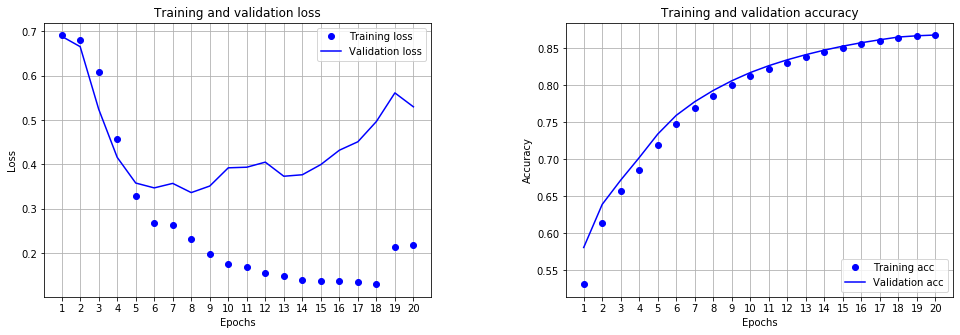

              precision    recall  f1-score   support

           0       0.79      0.85      0.82     12500
           1       0.84      0.77      0.80     12500

    accuracy                           0.81     25000
   macro avg       0.81      0.81      0.81     25000
weighted avg       0.81      0.81      0.81     25000



In [16]:
class CustomAttention(tf.keras.layers.Layer):
  """Implements CustomAttention attention scoring using small neural networks.
  Works great for single classificaiton prediciton.
  Add multiple dense layer to increase attention neural netowrk (a1, a2, etc.).

  Temrinology:
    'max_len' refers to sequence maximum length
    'hidden_size' / 'query_depth' / 'alignments_size' refers to rnn_size.
    'key' / 'keys' are 'encoder outputs' related values with 
      shape `[batch_size x max_len x hidden size]`
    'query' / 'value'(s) refers to decoder values with 
      shape `[batch_size x hidden size]`

  Source:
  https://github.com/conversationai/conversationai-models/blob/master/attention-tutorial/Attention_Model_Tutorial.ipynb
  """
  def __init__(self, max_len, rnn_size, attention_size):
    """Construct the AttentionMechanism.

    Args:
      max_len: sequence maximum length.
      rnn_size: number of hidden units in rnn cell.
      attention_size: The size of layer for neural network scoring prediciton.
    """

    super(CustomAttention, self).__init__()
    self.max_len = max_len
    self.rnn_size = rnn_size
    # attention layer
    self.a1 = tf.keras.layers.Dense(units=attention_size, activation=tf.nn.relu)
    # last layer that outputs scoring value
    self.V = tf.keras.layers.Dense(1, activation=None)

  def call(self, encoder_output):
    """Score based on the decoder and encoder outputs.

    Args:
      encoder_output: Tensor with shape `[batch_size, rnn_size]`
    Returns:
      context: The weighted average sum of encoder output with 
        shape `[batch_size, rnn_size]`
      alignment: The attention with shape `[batch_size, max_len]`
    """
    # concatenate sequences vertically
    encoder_output = tf.concat(encoder_output, axis = 2)
    # reshape to [batch_size*max_len, rnn_size]
    intermediate_values = tf.reshape(encoder_output, [-1, self.rnn_size])
    # feed to each layer
    intermediate_values = self.a1(intermediate_values)
    intermediate_values = self.V(intermediate_values)
    # reshape to [batch_size, max_len, 1]
    scores = tf.reshape(intermediate_values, [-1, self.max_len, 1])
    alignment = tf.nn.softmax(logits=scores, axis=1)
    context_vector = tf.reduce_sum(encoder_output * alignment, 1)
    # match shape [batch_size, max_len]
    alignment = tf.squeeze(alignment)
    return context_vector, alignment


class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, rnn_size):
    super(Encoder, self).__init__()
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(rnn_size,
                                  return_sequences=True,
                                  return_state=True,
                                  recurrent_initializer='glorot_uniform')
  def call(self, input_batch):
    intermediate_value = self.embedding(input_batch)
    # not used initial_state = hidden
    encoder_outputs, last_output = self.gru(intermediate_value)
    return encoder_outputs, last_output


class Prediction(tf.keras.Model):
  def __init__(self):
    super(Prediction, self).__init__()
    # self.l1 = tf.keras.layers.Dense(units=units, activation=tf.nn.relu)
    self.l2 = tf.keras.layers.Dense(units=1, activation=tf.nn.sigmoid)
    return

  def call(self, input_batch):
    # intermediate_value = self.l1(input_batch)
    output_batch = self.l2(input_batch)
    return output_batch


def loss_func(target, logits):
  bce = tf.losses.BinaryCrossentropy(from_logits=False)
  return bce(y_true=target, y_pred=logits)


# need signature becuase each batch different shape
# @tf.function(input_signature=[
#     tf.TensorSpec(shape=[None, None], dtype=tf.int64),
#     tf.TensorSpec(shape=[None,], dtype=tf.int64)])
@tf.function
def train_batch(input_batch, labels_batch):
  # use global scope variables
  global encoder, custom_attn, pred_decoder, model_optimizer
  loss = 0
  with tf.GradientTape() as tape:
    encoder_outputs, last_output = encoder(input_batch)    
    context_vector, attention_weights = custom_attn(encoder_outputs)
    preds_batch = pred_decoder(context_vector)

    loss = loss_func(labels_batch, preds_batch)
    acc = model_metrics(labels_batch, tf.keras.backend.round(preds_batch))

  variables = encoder.variables + custom_attn.variables + pred_decoder.variables
  gradients = tape.gradient(loss, variables)
  model_optimizer.apply_gradients(zip(gradients, variables))
  return loss, acc, attention_weights

def model_predicitons(data_generator):
  """Predict on test data.
  Make sure train_generator is already batched formatted.
  """
  # models used
  global encoder, custom_attn, pred_decoder
  y_pred = []
  y_true = []
  attentions = []
  # make predicitons
  for batch, (inputs_batch, labels_batch) in enumerate(data_generator):
    encoder_outputs, _ = encoder(inputs_batch)    
    context_vector, attention_batch = custom_attn(encoder_outputs)
    preds_batch = pred_decoder(context_vector)
    preds_batch = tf.keras.backend.round(preds_batch)
    [y_pred.append(val[0]) for val in preds_batch]
    [y_true.append(val) for val in labels_batch]
    [attentions.append(val) for val in attention_batch]
  return np.array(y_true), np.array(y_pred), np.array(attentions)

EPOCHS = 20
history_dict = {'accuracy':[],
                'val_accuracy':[], 
                'loss':[], 
                'val_loss':[]}

with tf.device('/device:GPU:0'):
  
  encoder = Encoder(vocab_size=text_encoder.vocab_size, 
                    embedding_dim=EMBEDDING_SIZE, 
                    rnn_size=rnn_units)
  custom_attn = CustomAttention(max_len=MAX_LEN, 
                                rnn_size=rnn_units, 
                                attention_size=attention_dim)
  pred_decoder = Prediction()
  model_optimizer = tf.optimizers.Adam()
  model_metrics = tf.metrics.Accuracy()

  for epoch in range(EPOCHS):
    epoch_time = 0

    # train data
    loss_epoch = 0
    acc_epoch = 0

    for batch, (encodings_batch, labels_batch) in enumerate(train_batches, start=1):
      start_time = time.time()
      # train on batch
      loss_batch, acc_batch, attention_batch = train_batch(encodings_batch, labels_batch)
      # keep track of loss and accuracy
      loss_epoch += loss_batch
      acc_epoch += acc_batch
      end_time = time.time()
      epoch_time += (end_time - start_time)
        
    batch_time = epoch_time / batch
    loss_epoch = tf.get_static_value(loss_epoch) / batch
    history_dict['loss'].append(loss_epoch)
    acc_epoch = tf.get_static_value(acc_epoch) / batch
    history_dict['accuracy'].append(acc_epoch)

    # validation data
    val_acc_epoch = 0
    val_loss_epoch = 0

    for batch, (encodings_bacth, labels_batch) in enumerate(valid_batches, start=1):
      encoder_outputs, _ = encoder(encodings_bacth)    
      context_vector, attention_weights = custom_attn(encoder_outputs)
      preds_batch = pred_decoder(context_vector)

      val_loss_epoch += loss_func(labels_batch, preds_batch)
      val_acc_epoch += model_metrics(labels_batch, tf.keras.backend.round(preds_batch))

    val_loss_epoch = tf.get_static_value(val_loss_epoch) / batch
    history_dict['val_loss'].append(val_loss_epoch)

    val_acc_epoch = tf.get_static_value(val_acc_epoch) / batch
    history_dict['val_accuracy'].append(val_acc_epoch)

    print('Epoch: %s/%s loss: %.4f acc: %.4f val_loss: %.4f val_acc: %.4f\tTime epoch: %.2f batch: %.2f'%(epoch+1, 
                                                                                                        EPOCHS, 
                                                                                                        loss_epoch, 
                                                                                                        acc_epoch, 
                                                                                                        val_loss_epoch, 
                                                                                                        val_acc_epoch,
                                                                                                        epoch_time,
                                                                                                        batch_time))    
plt_history(history_dict)

# test model
y_true, y_pred, attentions = model_predicitons(test_data.batch(15000))
print(classification_report(y_true, y_pred))

#### CustomAttention - Whole Models

Epoch: 1/20 loss: 0.6918 acc: 0.5131 val_loss: 0.6891 val_acc: 0.5410 Time epoch: 10.90 batch: 0.61
Epoch: 2/20 loss: 0.6823 acc: 0.5819 val_loss: 0.6681 val_acc: 0.6163 Time epoch: 9.50 batch: 0.53
Epoch: 3/20 loss: 0.6163 acc: 0.6398 val_loss: 0.5279 val_acc: 0.6584 Time epoch: 9.74 batch: 0.54
Epoch: 4/20 loss: 0.4363 acc: 0.6759 val_loss: 0.3922 val_acc: 0.6950 Time epoch: 9.69 batch: 0.54
Epoch: 5/20 loss: 0.3078 acc: 0.7138 val_loss: 0.3408 val_acc: 0.7304 Time epoch: 9.48 batch: 0.53
Epoch: 6/20 loss: 0.2403 acc: 0.7455 val_loss: 0.3220 val_acc: 0.7585 Time epoch: 9.59 batch: 0.53
Epoch: 7/20 loss: 0.1966 acc: 0.7704 val_loss: 0.3348 val_acc: 0.7806 Time epoch: 9.36 batch: 0.52
Epoch: 8/20 loss: 0.1714 acc: 0.7901 val_loss: 0.3653 val_acc: 0.7980 Time epoch: 9.59 batch: 0.53
Epoch: 9/20 loss: 0.1543 acc: 0.8056 val_loss: 0.3734 val_acc: 0.8121 Time epoch: 9.50 batch: 0.53
Epoch: 10/20 loss: 0.1442 acc: 0.8183 val_loss: 0.3912 val_acc: 0.8234 Time epoch: 9.76 batch: 0.54
Epoch: 1

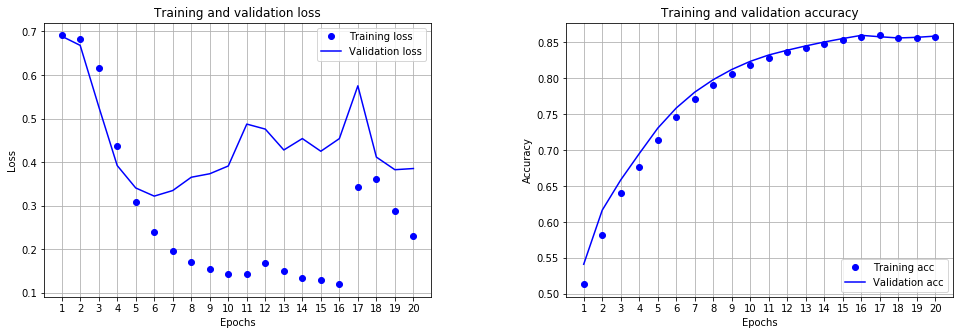

              precision    recall  f1-score   support

           0       0.81      0.82      0.82     12500
           1       0.82      0.81      0.82     12500

    accuracy                           0.82     25000
   macro avg       0.82      0.82      0.82     25000
weighted avg       0.82      0.82      0.82     25000



In [17]:
class AttentionBinaryModel(tf.keras.Model):
  def __init__(self, max_len, vocab_size, embedding_dim, rnn_size, attention_size):
    super(AttentionBinaryModel, self).__init__()
    self.rnn_size = rnn_size
    self.max_len = max_len
    # embedding layer
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    # rnn layers
    self.gru = tf.keras.layers.GRU(self.rnn_size,
                                  return_sequences=True,
                                  return_state=True,
                                  recurrent_initializer='glorot_uniform')
    # attention layers
    self.a1 = tf.keras.layers.Dense(units=attention_size, activation=tf.nn.relu)
    # last layer that outputs scoring value
    self.V = tf.keras.layers.Dense(1, activation=None)

    # prediciton layers
    # self.l1 = tf.keras.layers.Dense(units=16, activation=tf.nn.relu)
    self.l2 = tf.keras.layers.Dense(units=1, activation=tf.nn.sigmoid)

    return

  def call(self, input_batch):
    intermediate_values = self.embedding(input_batch)
    encoder_outputs, last_output = self.gru(intermediate_values)

    # concatenate sequences vertically
    encoder_outputs = tf.concat(encoder_outputs, axis = 2)
    # reshape to [batch_size*max_len, rnn_size]
    intermediate_values = tf.reshape(encoder_outputs, [-1, self.rnn_size])
    # feed to each layer
    intermediate_values = self.a1(intermediate_values)
    intermediate_values = self.V(intermediate_values)
    # reshape to [batch_size, max_len, 1]
    scores = tf.reshape(intermediate_values, [-1, self.max_len, 1])
    alignment = tf.nn.softmax(logits=scores, axis=1)
    context_vector = tf.reduce_sum(encoder_outputs * alignment, 1)
    # match shape [batch_size, max_len]
    alignment = tf.squeeze(alignment)

    # predicitons
    # intermediate_values = self.l1(context_vector)
    output_batch = self.l2(context_vector)

    return output_batch, alignment

def loss_func(target, logits):
  bce = tf.losses.BinaryCrossentropy(from_logits=False)
  return bce(y_true=target, y_pred=logits)

@tf.function
def train_batch(input_batch, labels_batch):
  # use global scope variables
  global whole_model, model_optimizer, model_optimizer

  with tf.GradientTape() as tape:
    preds_batch, attention = whole_model(input_batch)
    loss = loss_func(labels_batch, preds_batch)
    acc = model_metrics(labels_batch, tf.keras.backend.round(preds_batch))

  variables = whole_model.variables
  gradients = tape.gradient(loss, variables)
  model_optimizer.apply_gradients(zip(gradients, variables))
  return loss, acc, attention

def model_predicitons(data_generator):
  """Predict on test data.
  Make sure train_generator is already batched formatted.
  """
  # models used
  global whole_model
  y_pred = []
  y_true = []
  attentions = []
  # make predicitons
  for batch, (inputs_batch, labels_batch) in enumerate(data_generator):
    preds_batch, attention_batch = whole_model(inputs_batch)
    preds_batch = tf.keras.backend.round(preds_batch)
    [y_pred.append(val[0]) for val in preds_batch]
    [y_true.append(val) for val in labels_batch]
    [attentions.append(val) for val in attention_batch]
  return np.array(y_true), np.array(y_pred), np.array(attentions)

# model history
history_dict = {'accuracy':[],
                'val_accuracy':[], 
                'loss':[], 
                'val_loss':[]}

with tf.device('/device:GPU:0'):
  # create whole model
  whole_model = AttentionBinaryModel(max_len=MAX_LEN, 
                                      vocab_size=text_encoder.vocab_size,
                                      embedding_dim=EMBEDDING_SIZE,
                                      rnn_size=rnn_units,
                                      attention_size=attention_dim)
  # loss function
  model_optimizer = tf.optimizers.Adam()
  # metrics to monitor
  model_metrics = tf.metrics.Accuracy()

  EPOCHS = 20

  for epoch in range(EPOCHS):
    epoch_time = 0

    # train data
    loss_epoch = 0
    acc_epoch = 0

    for batch, (encodings_batch, labels_batch) in enumerate(train_batches, start=1):
      start_time = time.time()
      # train on batch
      loss_batch, acc_batch, attention_batch = train_batch(encodings_batch, labels_batch)
      # keep track of loss and accuracy
      loss_epoch += loss_batch
      acc_epoch += acc_batch
      end_time = time.time()
      epoch_time += (end_time - start_time)
        
    batch_time = epoch_time / batch
    loss_epoch = tf.get_static_value(loss_epoch) / batch
    history_dict['loss'].append(loss_epoch)
    acc_epoch = tf.get_static_value(acc_epoch) / batch
    history_dict['accuracy'].append(acc_epoch)

    # validation data
    val_acc_epoch = 0
    val_loss_epoch = 0

    for batch, (encodings_bacth, labels_batch) in enumerate(valid_batches, start=1):
      preds_batch, attention = whole_model(encodings_bacth)
      val_loss_epoch += loss_func(labels_batch, preds_batch)
      val_acc_epoch += model_metrics(labels_batch, tf.keras.backend.round(preds_batch))

    val_loss_epoch = tf.get_static_value(val_loss_epoch) / batch
    history_dict['val_loss'].append(val_loss_epoch)

    val_acc_epoch = tf.get_static_value(val_acc_epoch) / batch
    history_dict['val_accuracy'].append(val_acc_epoch)

    print('Epoch: %s/%s loss: %.4f acc: %.4f val_loss: %.4f val_acc: %.4f Time epoch: %.2f batch: %.2f'%(epoch+1, 
                                                                                                        EPOCHS, 
                                                                                                        loss_epoch, 
                                                                                                        acc_epoch, 
                                                                                                        val_loss_epoch, 
                                                                                                        val_acc_epoch,
                                                                                                        epoch_time,
                                                                                                        batch_time))    
plt_history(history_dict)

# test model
y_true, y_pred, attentions = model_predicitons(test_data.batch(15000))
print(classification_report(y_true, y_pred))

#### BahdanauAttention - Separate Models

Epoch: 1/20 loss: 0.6916 acc: 0.5340 val_loss: 0.6883 val_acc: 0.5832	Time epoch: 10.91 batch: 0.61
Epoch: 2/20 loss: 0.6786 acc: 0.6199 val_loss: 0.6576 val_acc: 0.6402	Time epoch: 9.01 batch: 0.50
Epoch: 3/20 loss: 0.5786 acc: 0.6559 val_loss: 0.4928 val_acc: 0.6721	Time epoch: 9.12 batch: 0.51
Epoch: 4/20 loss: 0.3888 acc: 0.6905 val_loss: 0.3754 val_acc: 0.7101	Time epoch: 8.98 batch: 0.50
Epoch: 5/20 loss: 0.2737 acc: 0.7283 val_loss: 0.3329 val_acc: 0.7444	Time epoch: 9.07 batch: 0.50
Epoch: 6/20 loss: 0.2103 acc: 0.7590 val_loss: 0.3255 val_acc: 0.7714	Time epoch: 8.86 batch: 0.49
Epoch: 7/20 loss: 0.1677 acc: 0.7830 val_loss: 0.3402 val_acc: 0.7927	Time epoch: 8.86 batch: 0.49
Epoch: 8/20 loss: 0.1358 acc: 0.8022 val_loss: 0.3842 val_acc: 0.8099	Time epoch: 9.09 batch: 0.51
Epoch: 9/20 loss: 0.1130 acc: 0.8175 val_loss: 0.4681 val_acc: 0.8236	Time epoch: 9.13 batch: 0.51
Epoch: 10/20 loss: 0.1031 acc: 0.8296 val_loss: 0.5219 val_acc: 0.8344	Time epoch: 8.88 batch: 0.49
Epoch: 1

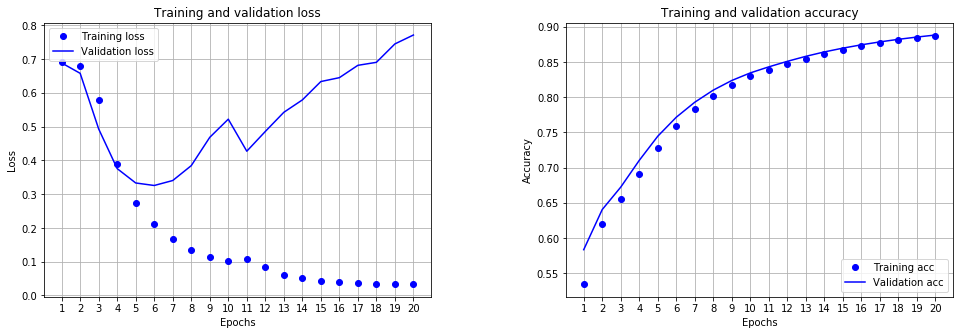

              precision    recall  f1-score   support

           0       0.83      0.77      0.80     12500
           1       0.78      0.85      0.81     12500

    accuracy                           0.81     25000
   macro avg       0.81      0.81      0.81     25000
weighted avg       0.81      0.81      0.81     25000



In [18]:
class BahdanauAttention(tf.keras.layers.Layer):
  """Implements BahdanauAttention attention scoring.

  Temrinology:
    'max_len' refers to sequence maximum length
    'rnn_size' / 'hidden_size' / 'query_depth' / 'alignments_size' refers 
      to RNN size.
    'key' / 'keys' are 'encoder outputs' related values with 
      shape `[batch_size x max_len x hidden size]`
    'query' / 'value'(s) refers to decoder values with 
      shape `[batch_size x hidden size]`

  Source:
  https://github.com/tensorflow/docs/blob/master/site/en/tutorials/text/nmt_with_attention.ipynb
  """
  def __init__(self, units):
    """Construct the AttentionMechanism.

    Args:
      units: number of neurons in layer of neural network scoring aproximation.
    """
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, encoder_output):
    """Score the query based on the decoder and encoder outputs.

    Args:
      decoder_input: Tensor with shape `[batch_size, rnn_size]`.
      encoder_output: Tensor with shape `[batch_size, max_len, rnn_size]`
    Returns:
      context: The weighted average sum of encoder output with 
        shape `[batch_size, rnn_size]`
      alignment: The attention with shape `[batch_size, max_len]`
    """
    
    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(self.W1(encoder_output)))
    # alignment shape == (batch_size, max_length, 1)
    alignment = tf.nn.softmax(score, axis=1)
    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = alignment * encoder_output
    context_vector = tf.reduce_sum(context_vector, axis=1)
    # match shape [batch_size, max_len]
    alignment = tf.squeeze(alignment)
    return context_vector, alignment


class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, rnn_size):
    super(Encoder, self).__init__()
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(rnn_size,
                                  return_sequences=True,
                                  return_state=True,
                                  recurrent_initializer='glorot_uniform')
  def call(self, input_batch):
    intermediate_value = self.embedding(input_batch)
    # not used initial_state = hidden
    encoder_outputs, last_output = self.gru(intermediate_value)
    return encoder_outputs, last_output


class Prediction(tf.keras.Model):
  def __init__(self):
    super(Prediction, self).__init__()
    # self.l1 = tf.keras.layers.Dense(units=units, activation=tf.nn.relu)
    self.l2 = tf.keras.layers.Dense(units=1, activation=tf.nn.sigmoid)
    return

  def call(self, input_batch):
    # intermediate_value = self.l1(input_batch)
    output_batch = self.l2(input_batch)
    return output_batch


def loss_func(target, logits):
  bce = tf.losses.BinaryCrossentropy(from_logits=False)
  return bce(y_true=target, y_pred=logits)


# need signature becuase each batch different shape
# @tf.function(input_signature=[
#     tf.TensorSpec(shape=[None, None], dtype=tf.int64),
#     tf.TensorSpec(shape=[None,], dtype=tf.int64)])
@tf.function
def train_batch(input_batch, labels_batch):
  # use global scope variables
  global encoder, custom_attn, pred_decoder, model_optimizer
  loss = 0
  with tf.GradientTape() as tape:
    encoder_outputs, last_output = encoder(input_batch)    
    context_vector, attention_weights = custom_attn(encoder_outputs)
    preds_batch = pred_decoder(context_vector)

    loss = loss_func(labels_batch, preds_batch)
    acc = model_metrics(labels_batch, tf.keras.backend.round(preds_batch))

  variables = encoder.variables + custom_attn.variables + pred_decoder.variables
  gradients = tape.gradient(loss, variables)
  model_optimizer.apply_gradients(zip(gradients, variables))
  return loss, acc, attention_weights

def model_predicitons(data_generator):
  """Predict on test data.
  Make sure train_generator is already batched formatted.
  """
  # models used
  global encoder, custom_attn, pred_decoder
  y_pred = []
  y_true = []
  attentions = []
  # make predicitons
  for batch, (inputs_batch, labels_batch) in enumerate(data_generator):
    encoder_outputs, _ = encoder(inputs_batch)    
    context_vector, attention_batch = custom_attn(encoder_outputs)
    preds_batch = pred_decoder(context_vector)
    preds_batch = tf.keras.backend.round(preds_batch)
    [y_pred.append(val[0]) for val in preds_batch]
    [y_true.append(val) for val in labels_batch]
    [attentions.append(val) for val in attention_batch]
  return np.array(y_true), np.array(y_pred), np.array(attentions)

EPOCHS = 20
history_dict = {'accuracy':[],
                'val_accuracy':[], 
                'loss':[], 
                'val_loss':[]}

with tf.device('/device:GPU:0'):
  
  encoder = Encoder(vocab_size=text_encoder.vocab_size, 
                    embedding_dim=EMBEDDING_SIZE, 
                    rnn_size=rnn_units)
  custom_attn = BahdanauAttention(units=10)
  pred_decoder = Prediction()
  model_optimizer = tf.optimizers.Adam()
  model_metrics = tf.metrics.Accuracy()

  for epoch in range(EPOCHS):
    epoch_time = 0

    # train data
    loss_epoch = 0
    acc_epoch = 0

    for batch, (encodings_batch, labels_batch) in enumerate(train_batches, start=1):
      start_time = time.time()
      # train on batch
      loss_batch, acc_batch, attention_batch = train_batch(encodings_batch, labels_batch)
      # keep track of loss and accuracy
      loss_epoch += loss_batch
      acc_epoch += acc_batch
      end_time = time.time()
      epoch_time += (end_time - start_time)
        
    batch_time = epoch_time / batch
    loss_epoch = tf.get_static_value(loss_epoch) / batch
    history_dict['loss'].append(loss_epoch)
    acc_epoch = tf.get_static_value(acc_epoch) / batch
    history_dict['accuracy'].append(acc_epoch)

    # validation data
    val_acc_epoch = 0
    val_loss_epoch = 0

    for batch, (encodings_bacth, labels_batch) in enumerate(valid_batches, start=1):
      encoder_outputs, _ = encoder(encodings_bacth)    
      context_vector, attention_weights = custom_attn(encoder_outputs)
      preds_batch = pred_decoder(context_vector)

      val_loss_epoch += loss_func(labels_batch, preds_batch)
      val_acc_epoch += model_metrics(labels_batch, tf.keras.backend.round(preds_batch))

    val_loss_epoch = tf.get_static_value(val_loss_epoch) / batch
    history_dict['val_loss'].append(val_loss_epoch)

    val_acc_epoch = tf.get_static_value(val_acc_epoch) / batch
    history_dict['val_accuracy'].append(val_acc_epoch)

    print('Epoch: %s/%s loss: %.4f acc: %.4f val_loss: %.4f val_acc: %.4f\tTime epoch: %.2f batch: %.2f'%(epoch+1, 
                                                                                                        EPOCHS, 
                                                                                                        loss_epoch, 
                                                                                                        acc_epoch, 
                                                                                                        val_loss_epoch, 
                                                                                                        val_acc_epoch,
                                                                                                        epoch_time,
                                                                                                        batch_time))    
plt_history(history_dict)

# test model
y_true, y_pred, attentions = model_predicitons(test_data.batch(15000))
print(classification_report(y_true, y_pred))